# ICE Training Data Extraction Experiments

In [3]:
import pandas as pd
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random
import logging
import sys
import time
import multiprocessing

threads = 32
# number of repetitions per experiment
N = 100

This notebook will go through the experiment for training data extraction with individual conditional expectation (ICE). Training data extraction means an attacker can find out the feature values of samples from the training data without prior knowledge of them. The attacker only has access to the model's prediction function and the explanation.

The idea for ICE training data extraction is as follows: The attacker can check which predictions values are the same for different ICE lines from the same training sample (each training sample has one ICE line for every feature). If there is only one possible combination of feature values with the same prediction value, then these feature values must make up the original sample. If multiple possibilites exist, then false training data samples must be excluded by checking whether the model's prediction matches the prediction in the ICE graphs. We can further reduce the number of candidates by performing membership inference with ICE on them.

First, we define a few functions that will help us run the experiment later.

The first function performs membership inference in order to help the training data extraction discard false candidates.

In [1]:
# sample: numpy array with feature values of one sample
# ice_features: list of ice explanations (one for each feature)
# pred_func: prediction function by model. Takes an array of samples and returns array of predictions.
# class_num: index for output of pred_func: class to consider for ice explanation
# sample_index: index of the sample in the ICE lines.
# returns: true if sample appears to be part of training data, false otherwise
def membership_inference_ice_fast(sample, ice_features, pred_func, class_num, sample_index):
    
    # Recreate ice lines for all given features for the sample.

    for num, ice in enumerate(ice_features):
        
        # Get the grid for this feature. These are the points at which we will get predictions from the model.
        feature_values = ice['values'][0]

        # Create array that contains the sample as many times as there are different grid points for this feature.
        changed_samples = np.tile(sample, (feature_values.shape[0], 1))
        
        # Change each copied samples feature in question to a point from the grid.
        changed_samples[:, num] = feature_values
        
        # Get the predictions for these changed samples.
        preds = pred_func(changed_samples)[:, 1]
        
        # Compare the predictions to the actual ICE line for this sample. If they match, continue with the next feature.
        # Otherwise this sample is not part of the training data. Return false.
        if not np.allclose(preds, ice['individual'][0, sample_index]):
            return False
        
    # This is only reached if the ICE line matched for every feature. 
    # Return true to predict that the sample was in training data.
    return True

The second function can execute training data extraction for ICE explanations. It takes a list of ICE explanations (for different features), the index of the sample to extract and the prediction function of the machine learning model. The function returns a list of candidates for that sample. If only one candidate is returned and it matches the original sample then it has been succesfully extracted. The success rate of the extraction is tested in the following experiments.

In [3]:
# ice_features: list of ice explanations (one for each feature)
# pred_func: prediction function by model. Takes an array of samples and returns array of predictions.
# sample_index: index of the sample to extract in the ICE lines.
# max_precandidates: maximum number of precandidates (all possible combinations of feature values that share a prediction value)
#                    to create. If the possible combinations exceed this number, they won't be created and that prediction value
#                    will be skipped.
# max_candidates: maximum number of candidates for which membership inference will be executed. If the number of candidates 
#                 exceeds this number, they will be discarded and an empty list of candidates for the sample is returned.
# returns: list of candidates for the sample with sample_index in the ICE lines
def training_data_extraction_ice(ice_features, pred_func, sample_index, max_precandidates=1E8, max_candidates=1E5):
    
    num_of_features = len(ice_features)
    
    # Create array that contains all predictions values that are shared across all ICE lines for this sample.
    shared_preds = ice_features[0]['individual'][0][sample_index]
    for i in range(num_of_features):
        shared_preds = np.intersect1d(shared_preds, ice_features[i]['individual'][0][sample_index])

    # This list will contain arrays of candidates. Each array belongs to one shared prediction value.
    sample_candidates_list = []
    
    # Number of found candidates so far.
    num_of_candidates = 0

    for prediction in shared_preds:

        # Each element of this list will be one array with the possible values for that feature.
        # These values are at the points where the shared prediction value appears for the feature.
        values_for_each_feature = []
        
        # The values for all features must be combined in all possible ways to create the plausible training data samples.
        # The number of possible combinations are counted first to avoid allocating to much memory 
        # in case there are too many possibilities.
        combinations = 1

        for i in range(num_of_features):
            
            # Get indices where the ICE lines prediction is equal to the shared prediction.
            indices = np.where(ice_features[i]['individual'][0][sample_index] == prediction)[0]
            
            # Get the feature values for those indices and add them to the list.
            values = ice_features[i]['values'][0][indices]
            values_for_each_feature.append(values)
            
            # Update possible combinations counter.
            combinations = combinations * values.shape[0]
            
        # Skip creating the possible combinations for this shared prediction value if they exceed the threshhold.
        if combinations > max_precandidates:
            logging.debug("Sample index %s: %s precandidates exceeds limit. Skipping prediction value %s." \
                          % (sample_index, combinations, prediction))
            continue

        logging.debug("Sample index %s: creating %s precandidates for prediction value %s." \
                      % (sample_index, combinations, prediction))
            
        # Create precandidates by finding all possible combinations of the possible feature values.
        sample_precandidates = np.array(np.meshgrid(*values_for_each_feature)).T.reshape(-1, num_of_features)

        # Get the model's predictions for these precandidates.
        actual_preds = pred_func(sample_precandidates)[:, 1]

        # Only select precandidates that match the shared prediction and add them to the list
        sample_candidates = sample_precandidates[np.where(actual_preds == prediction)]
        sample_candidates_list.append(sample_candidates)
        
        # Update number of found candidates
        num_of_candidates += sample_candidates.shape[0]

        # Abort if number of found candidates already exceeds the limit
        if num_of_candidates > max_candidates:
            logging.debug("Sample index %s: %s candidates exceeds limit. No result." % (sample_index, num_of_candidates))
            return []
    
    logging.debug("Sample index %s: checking %s candidates." % (sample_index, num_of_candidates))
    
    # List of candidates for which membership inference confirms their existence in the training data.
    final_candidates = []
    
    # Iterate over every candidate for every shared prediction and check if membership can be inferred for them.
    # If yes, add them to the final candidates.
    for cands in sample_candidates_list:
        for candidate in cands:
            if membership_inference_ice_fast(candidate, ice_features, pred_func, 1, sample_index):
                final_candidates.append(candidate)
            
    # Return the list of final candidates.
    return final_candidates

This function takes multiple sample indices and executes training data extraction on each of them. It is necessary in order to parallalize the algorithm.

In [4]:
# ice_features: list of ice explanations (one for each feature)
# pred_func: prediction function by model. Takes an array of samples and returns array of predictions.
# sample_indices: numpy array of indices of samples to extract. They point to the corresponding ICE lines.
# max_precandidates: maximum number of precandidates (all possible combinations of feature values that share a prediction value)
#                    to create. If the possible combinations exceed this number, they won't be created and that prediction value
#                    will be skipped.
# max_candidates: maximum number of candidates for which membership inference will be executed. If the number of candidates 
#                 exceeds this number, they will be discarded and an empty list of candidates for the sample is returned.
# returns: list of lists of candidates for the samples with the given indices in the ICE lines
def training_data_extraction_ice_multiple(ice_features, pred_func, sample_indices, max_precandidates=1E8, max_candidates=1E5):
    
    results = []
    
    # executes training data extraction for each sample index
    for sample_index in sample_indices:
        results.append(training_data_extraction_ice(ice_features, pred_func, sample_index, max_precandidates, max_candidates))
        
    return results

This function calculates the ICE graphs. It is also needed for parallelization because the `multiprocessing` package does not work with keyword arguments.

In [5]:
# clf: a classifier for which ICE is supposed to be calculated
# features: the training data of the classifier. ICE lines will be created for these samples.
# feature_index: index of feature for which ICE is supposed to be calculated
# grid: number of points on the grid for ICE
# returns: ICE (result of partial_dependence function)
def ice_for_features(clf, features, feature_index, grid):
    
    
    values = partial_dependence(estimator=clf, X=features, features=[feature_index], percentiles=(0,1), \
                                               grid_resolution=grid, kind='individual')
    
    logging.debug('Calculated ICE for feature %s' % feature_index)
    
    return values

Next, we will define a function that executes the entire experiment. It takes the features and the labels as panda dataframes. Random sample indices are supplied to the training data extraction algorithm which returns a list of candidates for each of them. The experiment function checks how many candidates are returned and whether the original sample is among them.

In [6]:
# features: pandas dataframe of the features for all training samples
# labels: pandas dataframe of the labels for all training samples
# number_of_extractions: number of samples to attempt to extract from the training data
# random_state: seed for randomness during experiment (needed for reproducability)
# returns: hit_percentage (likelihood of finding at least one candidate for a sample) and accuracy (likelihood of a candidate
#          to be an actual trainign sample)
def experiment(features, labels, number_of_extractions, random_state=39,\
               clf=es.RandomForestClassifier(random_state=17)):
    
    rs = np.random.RandomState(seed=random_state)
    random.seed(random_state)
    
    # Train classifier.
    clf = clf.fit(features, labels)
    
    num_of_samples = features.shape[0]
    num_of_features = features.shape[1]
    
    # Calculate ICE for all features in parallel
    logging.debug("Calculating ICE...")
    
    arg_list = []
    
    for i in range(num_of_features):
        # grid_resolution must be greater than the number of samples so that the grid points are forced to correspond
        # to the actual values of the training samples. Otherwise there may be possible feature values that do not 
        # appear on the grid.
        arg_list.append((clf, features, i, num_of_samples + 1))
    
    with multiprocessing.Pool(threads) as p:
        ice_features = p.starmap(ice_for_features, arg_list)
    
    logging.debug("ICE calculation done")
        
    # Begin experiment. Record number of correct and incorrect samples.
    num_of_times_candidates_found = 0
    num_of_found_samples = 0
    num_of_total_candidates = 0
    perfect_findings = 0
    
    # Indices of samples to test training data extraction for
    test_samples_indices = np.empty(number_of_extractions, dtype=int)
    # Actual values of samples to test training data extraction for
    test_samples = np.empty((number_of_extractions, num_of_features))
    
    # Fill the two created arrays with random samples and their indices
    for i in range(number_of_extractions):
        # Choose random sample.
        index = int(random.uniform(0, 1) * num_of_samples)
        test_samples_indices[i] = index
        test_samples[i] = features.iloc[index].to_numpy()
        
    arg_list = []
    
    samples_per_thread = number_of_extractions / threads
    
    for i in range(threads):
        start_idx = int(i * samples_per_thread)
        end_idx = int((i + 1) * samples_per_thread)
        arg_list.append((ice_features, clf.predict_proba, test_samples_indices[start_idx : end_idx]))
        
    logging.debug("Begin training data extraction for selected samples:")
    
    with multiprocessing.Pool(threads) as p:
        results = p.starmap(training_data_extraction_ice_multiple, arg_list)
        
    results_flat = [item for sublist in results for item in sublist]
    
    for i, candidates in enumerate(results_flat):
        test_sample = test_samples[i]
        test_sample_index = test_samples_indices[i]
        
        num_of_candidates = len(candidates)
        
        logging.debug("%s with index %s chosen as test sample" % (test_sample, test_sample_index))
        logging.debug("Found candidates: ")
        logging.debug(candidates)
        
        # Update counters.
        if num_of_candidates > 0:
            num_of_times_candidates_found += 1
            num_of_total_candidates += num_of_candidates
            
            if (test_sample == candidates).all(1).any():
                logging.debug("Sample is part of candidates.")
                num_of_found_samples += 1
                
                if num_of_candidates == 1:
                    perfect_findings += 1
                
    logging.debug('Number of times candidates were found: %s' % num_of_times_candidates_found)
    logging.debug('Number of total candidates: %s' % num_of_total_candidates)
    logging.debug('Number of found samples: %s' % num_of_found_samples)
    logging.debug('Number of only candidate being the sample: %s' % perfect_findings)
    
    # Likelihood of the sample being inside the found candidates
    accuracy_relaxed = num_of_found_samples / number_of_extractions
    
    # Likelihood of finding exactly one candidate that is the sample in question
    accuracy = perfect_findings / number_of_extractions
    
    print("Likelihood of the sample being inside the found candidates: %s" % accuracy_relaxed)
    print("Likelihood of finding exactly one candidate that is the sample in question: %s" % accuracy)
    
    return accuracy_relaxed, accuracy

# Dataset 1: Heart Disease

Load dataset one: heart disease

In [4]:
filename = '../data/framingham.csv'

names = ['sex', 'age', 'education', 'smoker', 'cigs_per_day', 'bp_meds', 'prevalent_stroke', 'prevelant_hyp', 'diabetes', \
         'total_chol', 'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose', 'heart_disease_label']

data = pd.read_csv(filename, names=names)

For this dataset we only look at numerical data so we drop the categorical columns. We also drop the column "education" for which there is no feature description on kaggle: https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression

In [5]:
data_num = data.drop('sex', axis=1).drop('smoker', axis=1).drop('bp_meds', axis=1).drop('prevalent_stroke', axis=1)\
    .drop('prevelant_hyp', axis=1).drop('diabetes', axis=1).drop('education', axis=1)

data_num.head(5)

,age,cigs_per_day,total_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,heart_disease_label
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0,0


Remove any rows that are missing data. Afterwards there should be no more entries with NaN values. We also drop any duplicate rows.

In [9]:
data_num = data_num.dropna()
data_num = data_num.drop_duplicates()

data_num.isnull().sum()

age                    0
cigs_per_day           0
total_chol             0
sys_bp                 0
dia_bp                 0
bmi                    0
heart_rate             0
glucose                0
heart_disease_label    0
dtype: int64

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for training data extraction.

The dark blue lines represent the average change in predictions for a change in the specified feature. The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

In [11]:
features = data_num.drop('heart_disease_label', axis=1)
labels = data_num['heart_disease_label']

data_num_100 = data_num.sample(n = 100, random_state=13)
features_100 = data_num_100.drop('heart_disease_label', axis=1)
labels_100 = data_num_100['heart_disease_label']

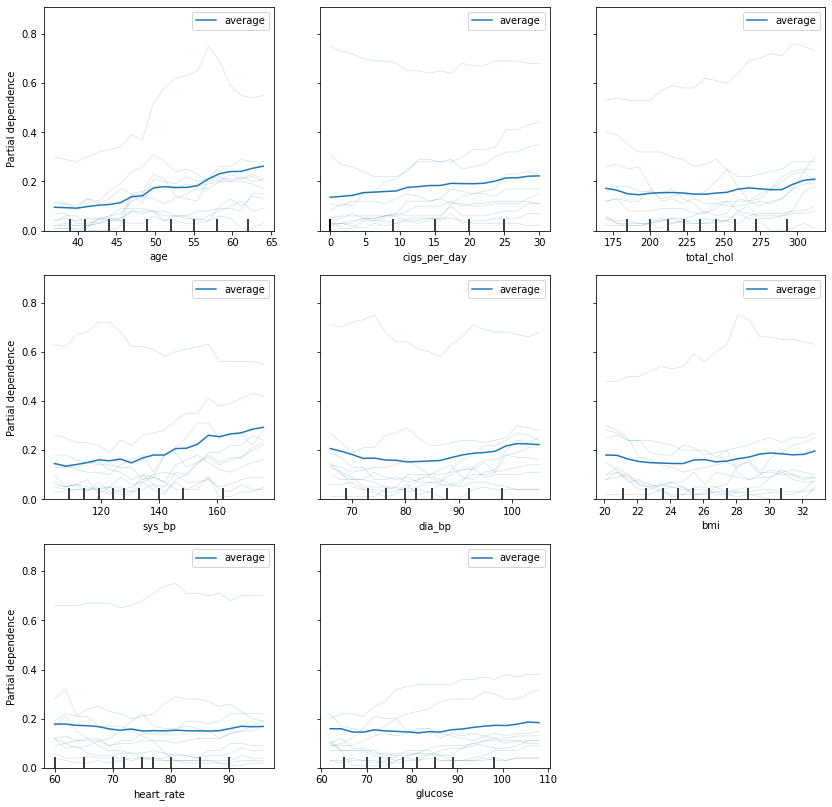

In [12]:
# Train a random forest classifier on training data.
clf = es.RandomForestClassifier(random_state=0)
clf = clf.fit(features, labels)

feature_names = ['age', 'cigs_per_day', 'total_chol', 'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose']
num_of_features = 8

fig, ax = plt.subplots(figsize=(14, 14))

display = plot_partial_dependence(
       clf, features, feature_names, kind="both", subsample=10,
       n_jobs=3, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

As a proof of concept for our privacy attack, we run the experiment for a few iterations with logging to show that the training data extraction function works in principle.

In [13]:
start = time.time()

logging.root.setLevel(logging.DEBUG)

experiment(features, labels, number_of_extractions=8, random_state=0)

logging.root.setLevel(logging.INFO)

print("--- %s seconds ---" % (time.time() - start))

DEBUG:root:Calculating ICE...
DEBUG:root:Calculated ICE for feature 1
DEBUG:root:Calculated ICE for feature 0
DEBUG:root:Calculated ICE for feature 6
DEBUG:root:Calculated ICE for feature 7
DEBUG:root:Calculated ICE for feature 4
DEBUG:root:Calculated ICE for feature 3
DEBUG:root:Calculated ICE for feature 2
DEBUG:root:Calculated ICE for feature 5
DEBUG:root:ICE calculation done
DEBUG:root:Begin training data extraction for selected samples:
DEBUG:root:Sample index 3208: creating 332640 precandidates for prediction value 0.03.
DEBUG:root:Sample index 2880: creating 4274127 precandidates for prediction value 0.52.
DEBUG:root:Sample index 3208: 185702 candidates exceeds limit. No result.
DEBUG:root:Sample index 1598: 317757440 precandidates exceeds limit. Skipping prediction value 0.02.
DEBUG:root:Sample index 1598: creating 30429000 precandidates for prediction value 0.03.
DEBUG:root:Sample index 983: creating 2 precandidates for prediction value 0.68.
DEBUG:root:Sample index 983: check

Likelihood of the sample being inside the found candidates: 0.125
Likelihood of finding exactly one candidate that is the sample in question: 0.0
--- 618.1990509033203 seconds ---


The proof of concept should show that the training data extraction function can accurately extract samples, but not every time. You can change the random state to try out a few different runs with different ICE lines.

Now we execute the entire experiment for this dataset.

In [14]:
results_ = {'dataset': [], 'training_samples': [], 'model': [], \
            'accuracy_relaxed': [], 'accuracy': []}

results = pd.DataFrame(data = results_)

In [15]:
print("features: continuous, training samples: all, model: decision tree.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features, labels, number_of_extractions=N, random_state=1,\
                                      clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', 'decision tree', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, training samples: all, model: decision tree.
Likelihood of the sample being inside the found candidates: 0.0
Likelihood of finding exactly one candidate that is the sample in question: 0.0
--- 13.278495073318481 seconds ---


In [16]:
print("features: continuous, training samples: all, model: random forest.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features, labels, number_of_extractions=N, random_state=1,\
                                      clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', 'random forest', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, training samples: all, model: random forest.
Likelihood of the sample being inside the found candidates: 0.23
Likelihood of finding exactly one candidate that is the sample in question: 0.11
--- 1815.9372742176056 seconds ---


In [17]:
print("features: continuous, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_100, labels_100, number_of_extractions=N, random_state=1,\
                                      clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '100', 'decision tree', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, training samples: 100, model: decision tree.
Likelihood of the sample being inside the found candidates: 0.0
Likelihood of finding exactly one candidate that is the sample in question: 0.0
--- 1.1147220134735107 seconds ---


In [18]:
print("features: continuous, training samples: 100, model: random forest.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_100, labels_100, number_of_extractions=N, random_state=1,\
                                      clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '100', 'random forest', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, training samples: 100, model: random forest.
Likelihood of the sample being inside the found candidates: 0.5
Likelihood of finding exactly one candidate that is the sample in question: 0.08
--- 2155.658906698227 seconds ---


# Dataset 2: Census Income

Load dataset two: census income

In [6]:
filename = '../data/adult.data.csv'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', \
         'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label']

data_cat = pd.read_csv(filename, names=names)

data_cat.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There is missing data in the columns workclass and native_country that needs to be removed.

In [7]:
print("Unique values of columns before removal: ")
print(data_cat.workclass.unique())
print(data_cat.native_country.unique())

data_cat = data_cat[data_cat.workclass != ' ?']
data_cat = data_cat[data_cat.native_country != ' ?']

print("Unique values of columns after removal: ")
print(data_cat.workclass.unique())
print(data_cat.native_country.unique())

Unique values of columns before removal: 
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']
Unique values of columns after removal: 
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' United-States' ' Cuba' ' Jamaica' ' India' ' Mexico' ' Puerto-Rico'
 ' Honduras' ' England' ' Canada' ' Germany' ' Iran' ' Philippines'
 ' Poland' ' Colu

We will only use the categorical features of this dataset. Remove continuous columns:

In [8]:
data_cat = data_cat.drop('age', axis=1).drop('fnlwgt', axis=1).drop('education_num', axis=1).drop('capital_gain', axis=1)\
    .drop('capital_loss', axis=1).drop('hours_per_week', axis=1)

data_cat.head(3)

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,label
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K


Transform workclass, education, marital_status, occupation, relationship, race, sex and native_country into label encoded features:

In [9]:
data_cat['workclass_encoded'] = LabelEncoder().fit_transform(data_cat['workclass'])
data_cat['education_encoded'] = LabelEncoder().fit_transform(data_cat['education'])
data_cat['marital_status_encoded'] = LabelEncoder().fit_transform(data_cat['marital_status'])
data_cat['occupation_encoded'] = LabelEncoder().fit_transform(data_cat['occupation'])
data_cat['relationship_encoded'] = LabelEncoder().fit_transform(data_cat['relationship'])
data_cat['race_encoded'] = LabelEncoder().fit_transform(data_cat['race'])
data_cat['native_country_encoded'] = LabelEncoder().fit_transform(data_cat['native_country'])

data_cat = data_cat.drop('workclass', axis=1).drop('education', axis=1).drop('marital_status', axis=1)\
    .drop('occupation', axis=1).drop('relationship', axis=1).drop('race', axis=1).drop('native_country', axis=1)

data_cat.head(3)

,sex,label,workclass_encoded,education_encoded,marital_status_encoded,occupation_encoded,relationship_encoded,race_encoded,native_country_encoded
0,Male,<=50K,6,9,4,1,1,4,38
1,Male,<=50K,5,9,2,4,0,4,38
2,Male,<=50K,3,11,0,6,1,4,38


Transform label and sex into binary encoding:

In [10]:
data_cat['female'] = data_cat['sex'].map( {' Male': 0, ' Female': 1} )
data_cat['>50K'] = data_cat['label'].map( {' <=50K': 0, ' >50K': 1} )

data_cat = data_cat.drop('sex', axis=1).drop('label', axis=1)

data_cat.head(3)

,workclass_encoded,education_encoded,marital_status_encoded,occupation_encoded,relationship_encoded,race_encoded,native_country_encoded,female,>50K
0,6,9,4,1,1,4,38,0,0
1,5,9,2,4,0,4,38,0,0
2,3,11,0,6,1,4,38,0,0


In [24]:
data_cat = data_cat.drop_duplicates()

Now all variations of the training data extraction experiment will be executed for the second dataset.

In [25]:
features_cat = data_cat.drop('>50K', axis=1)
labels_cat = data_cat['>50K']

data_cat_100 = data_cat.sample(n = 100, random_state=13)
features_cat_100 = data_cat_100.drop('>50K', axis=1)
labels_cat_100 = data_cat_100['>50K'] 

In [26]:
print("features: categorical, training samples: all, model: decision tree.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_cat, labels_cat, number_of_extractions=N, random_state=1,\
                                      clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', 'decision tree', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, training samples: all, model: decision tree.
Likelihood of the sample being inside the found candidates: 0.25
Likelihood of finding exactly one candidate that is the sample in question: 0.02
--- 46.78488779067993 seconds ---


In [27]:
print("features: categorical, training samples: all, model: random forest.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_cat, labels_cat, number_of_extractions=N, random_state=1,\
                                      clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', 'random forest', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, training samples: all, model: random forest.
Likelihood of the sample being inside the found candidates: 0.99
Likelihood of finding exactly one candidate that is the sample in question: 0.92
--- 851.2708022594452 seconds ---


In [28]:
print("features: categorical, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_cat_100, labels_cat_100, number_of_extractions=N, random_state=1,\
                                      clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '100', 'decision tree', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, training samples: 100, model: decision tree.
Likelihood of the sample being inside the found candidates: 0.13
Likelihood of finding exactly one candidate that is the sample in question: 0.0
--- 72.30913805961609 seconds ---


In [29]:
print("features: categorical, training samples: 100, model: random forest.")

start_time = time.time()

accuracy_relaxed, accuracy = experiment(features_cat_100, labels_cat_100, number_of_extractions=N, random_state=1,\
                                      clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '100', 'random forest', accuracy_relaxed, accuracy]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, training samples: 100, model: random forest.
Likelihood of the sample being inside the found candidates: 1.0
Likelihood of finding exactly one candidate that is the sample in question: 0.71
--- 26.60749125480652 seconds ---


# Results

The results of all variations of the training data extraction experiment with ICE. In each experiment, samples and their indices were picked randomly from the training data. Each index along with the ICE explanation was given to the training data extraction function which returns a list of possible sample candidates for that index.

"Accuracy relaxed" measures the percentage of sample indices for which it was possible to extract the original sample. The orginal sample must be contained in the list of sample candidates. It is possible that other sample candidates are found which do not correspond to the original sample.

"Accuracy" measures the percentage of indices for which it was possible to extract the original sample without ambiguities. The original sample must be the only element in the list of sample candidates.

In [30]:
results

,dataset,training_samples,model,accuracy_relaxed,accuracy
0,continuous,all,decision tree,0.00,0.00
1,continuous,all,random forest,0.23,0.11
2,continuous,100,decision tree,0.00,0.00
3,continuous,100,random forest,0.50,0.08
4,categorical,all,decision tree,0.25,0.02
5,categorical,all,random forest,0.99,0.92
6,categorical,100,decision tree,0.13,0.00
7,categorical,100,random forest,1.00,0.71
